# Neural Machine Translation with Attention mechanism

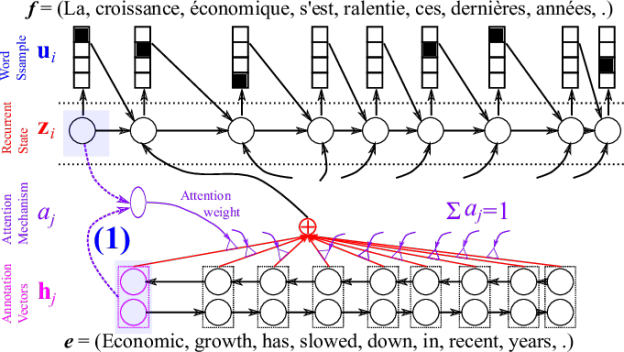

### What is Attention?

Attention is an interface between the encoder and decoder that provides the decoder with information from every encoder hidden state. With this setting, the model is able to selectively focus on useful parts of the input sequence and hence, learn the alignment between them. This helps the model to cope effectively with long input sentences .

In [1]:
!pip install chart-studio

     |████████████████████████████████| 64 kB 1.7 MB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf

#tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import time
import string

import chart_studio.plotly
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
#%plotly.offline.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/englishportuguese-translation/por.txt


### As in case of any NLP task, after reading the input file, we perform the basic cleaning and preprocessing as follows:

**The Dataset :** We need a dataset that contains English sentences and their Portuguese translations which can be freely downloaded from this [link](http://www.manythings.org/anki/). Download the file fra-eng.zip and extract it. On each line, the text file contains an English sentence and its French translation, separated by a tab.

In [4]:
file_path = '/kaggle/input/englishportuguese-translation/por.txt'

In [5]:
lines = open(file_path, encoding='UTF-8').read().strip().split('\n')
lines[5000:5010]

['Will it rain?\tSerá que chove?\tCC-BY 2.0 (France) Attribution: tatoeba.org #8918600 (CK) & #8930552 (JGEN)',
 'Wish me luck.\tDeseje-me sorte.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2254917 (CK) & #872788 (alexmarcelo)',
 "Won't you go?\tVocê não vai?\tCC-BY 2.0 (France) Attribution: tatoeba.org #241051 (CK) & #6212788 (bill)",
 'Write in ink.\tEscreva à tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351595 (alexmarcelo)',
 'Write in ink.\tEscreva a tinta.\tCC-BY 2.0 (France) Attribution: tatoeba.org #3258764 (CM) & #7351606 (alexmarcelo)',
 'Write to Tom.\tEscreva para o Tom.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2240357 (CK) & #5985551 (Ricardo14)',
 'Years passed.\tPassaram os anos.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #977841 (alexmarcelo)',
 'Years passed.\tAnos se passaram.\tCC-BY 2.0 (France) Attribution: tatoeba.org #282197 (CK) & #2324530 (Matheus)',
 'You amuse me.\tVocê me diverte.\tCC-BY 2.0 (France) Attributio

In [6]:
print("total number of records: ",len(lines))

total number of records:  168903


In [7]:
exclude = set(string.punctuation) # Set of all special characters
remove_digits = str.maketrans('', '', string.digits) # Set of all digits

### Function to preprocess English sentence

In [8]:
def preprocess_eng_sentence(sent):
    '''Function to preprocess English sentence'''
    sent = sent.lower() # lower casing
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    sent = sent.translate(remove_digits) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

### Function to preprocess Portuguese sentence

In [9]:
def preprocess_port_sentence(sent):
    '''Function to preprocess Portuguese sentence'''
    sent = re.sub("'", '', sent) # remove the quotation marks if any
    sent = ''.join(ch for ch in sent if ch not in exclude)
    #sent = re.sub("[२३०८१५७९४६]", "", sent) # remove the digits
    sent = sent.strip()
    sent = re.sub(" +", " ", sent) # remove extra spaces
    sent = '<start> ' + sent + ' <end>' # add <start> and <end> tokens
    return sent

### Generate pairs of cleaned English and Portuguese sentences with start and end tokens added.

In [10]:
# Generate pairs of cleaned English and Portuguese sentences
sent_pairs = []
for line in lines:
    sent_pair = []
    eng = line.rstrip().split('\t')[0]
    port = line.rstrip().split('\t')[1]
    eng = preprocess_eng_sentence(eng)
    sent_pair.append(eng)
    port = preprocess_port_sentence(port)
    sent_pair.append(port)
    sent_pairs.append(sent_pair)
sent_pairs[5000:5010]

[['<start> will it rain <end>', '<start> Será que chove <end>'],
 ['<start> wish me luck <end>', '<start> Desejeme sorte <end>'],
 ['<start> wont you go <end>', '<start> Você não vai <end>'],
 ['<start> write in ink <end>', '<start> Escreva à tinta <end>'],
 ['<start> write in ink <end>', '<start> Escreva a tinta <end>'],
 ['<start> write to tom <end>', '<start> Escreva para o Tom <end>'],
 ['<start> years passed <end>', '<start> Passaram os anos <end>'],
 ['<start> years passed <end>', '<start> Anos se passaram <end>'],
 ['<start> you amuse me <end>', '<start> Você me diverte <end>'],
 ['<start> you are late <end>', '<start> Você está atrasado <end>']]

### Create a class to map every word to an index and vice-versa for any given vocabulary.

In [11]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()

    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
            self.word2idx[word] = index + 1

        for word, index in self.word2idx.items():
            self.idx2word[index] = word

In [12]:
def max_length(tensor):
    return max(len(t) for t in tensor)

### Tokenization and Padding

In [13]:
def load_dataset(pairs, num_examples):
    # pairs => already created cleaned input, output pairs

    # index language using the class defined above    
    inp_lang = LanguageIndex(en for en, ma in pairs)
    targ_lang = LanguageIndex(ma for en, ma in pairs)
    
    # Vectorize the input and target languages
    
    # English sentences
    input_tensor = [[inp_lang.word2idx[s] for s in en.split(' ')] for en, ma in pairs]
    
    # Marathi sentences
    target_tensor = [[targ_lang.word2idx[s] for s in ma.split(' ')] for en, ma in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [14]:
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(sent_pairs, len(lines))

### Creating training and validation sets using an 80-20 split

In [15]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state = 101)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(152012, 152012, 16891, 16891)

In [16]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

We'll be using GRUs instead of LSTMs as we only have to create one state and implementation would be easier.

### Create GRU units

In [17]:
def gru(units):

    return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='sigmoid', 
                                   recurrent_initializer='glorot_uniform')


### The next step is to define the encoder and decoder network.

The input to the encoder will be the sentence in English and the output will be the hidden state and cell state of the GRU.

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

The next step is to define the decoder. The decoder will have two inputs: the hidden state and cell state from the encoder and the input sentence, which actually will be the output sentence with a token appended at the beginning.

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):

        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

Create encoder and decoder objects from their respective classes.

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

### Define the optimizer and the loss function.

In [21]:
optimizer = tf.optimizers.Adam()

def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

In [22]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training the Model

In [23]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every epoch
    checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))


Epoch 1 Batch 0 Loss 2.0035
Epoch 1 Batch 100 Loss 1.2797
Epoch 1 Batch 200 Loss 1.1187
Epoch 1 Batch 300 Loss 0.8724
Epoch 1 Batch 400 Loss 0.9314
Epoch 1 Batch 500 Loss 0.9364
Epoch 1 Batch 600 Loss 0.8944
Epoch 1 Batch 700 Loss 0.8355
Epoch 1 Batch 800 Loss 0.8299
Epoch 1 Batch 900 Loss 0.7560
Epoch 1 Batch 1000 Loss 0.6953
Epoch 1 Batch 1100 Loss 0.7366
Epoch 1 Batch 1200 Loss 0.6810
Epoch 1 Batch 1300 Loss 0.6348
Epoch 1 Batch 1400 Loss 0.7324
Epoch 1 Batch 1500 Loss 0.5894
Epoch 1 Batch 1600 Loss 0.6265
Epoch 1 Batch 1700 Loss 0.5628
Epoch 1 Batch 1800 Loss 0.5868
Epoch 1 Batch 1900 Loss 0.5012
Epoch 1 Batch 2000 Loss 0.5934
Epoch 1 Batch 2100 Loss 0.4831
Epoch 1 Batch 2200 Loss 0.4759
Epoch 1 Batch 2300 Loss 0.4576
Epoch 1 Loss 0.7347
Time taken for 1 epoch 1285.9424977302551 sec

Epoch 2 Batch 0 Loss 0.4504
Epoch 2 Batch 100 Loss 0.4087
Epoch 2 Batch 200 Loss 0.4878
Epoch 2 Batch 300 Loss 0.4053
Epoch 2 Batch 400 Loss 0.4674
Epoch 2 Batch 500 Loss 0.3853
Epoch 2 Batch 600 Loss 

### Restoring the latest checkpoint

In [24]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Inference setup and testing:

In [25]:
def evaluate(inputs, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    sentence = ''
    for i in inputs[0]:
        if i == 0:
            break
        sentence = sentence + inp_lang.idx2word[i] + ' '
    sentence = sentence[:-1]
    
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


### Function to predict (translate) a randomly selected test point


In [26]:
def predict_random_val_sentence():
    actual_sent = ''
    k = np.random.randint(len(input_tensor_val))
    random_input = input_tensor_val[k]
    random_output = target_tensor_val[k]
    random_input = np.expand_dims(random_input,0)
    result, sentence, attention_plot = evaluate(random_input, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
    print('Input: {}'.format(sentence[8:-6]))
    print('Predicted translation: {}'.format(result[:-6]))
    for i in random_output:
        if i == 0:
            break
        actual_sent = actual_sent + targ_lang.idx2word[i] + ' '
    actual_sent = actual_sent[8:-7]
    print('Actual translation: {}'.format(actual_sent))
    attention_plot = attention_plot[:len(result.split(' '))-2, 1:len(sentence.split(' '))-1]
    sentence, result = sentence.split(' '), result.split(' ')
    sentence = sentence[1:-1]
    result = result[:-2]

    # use plotly to generate the heat map
    trace = go.Heatmap(z = attention_plot, x = sentence, y = result, colorscale='greens')
    data=[trace]
    iplot(data)


In [27]:
predict_random_val_sentence()

Input: i dont know toms full name
Predicted translation: Eu não conheço o nome do Tom 
Actual translation: Eu não sei o nome completo de Tom


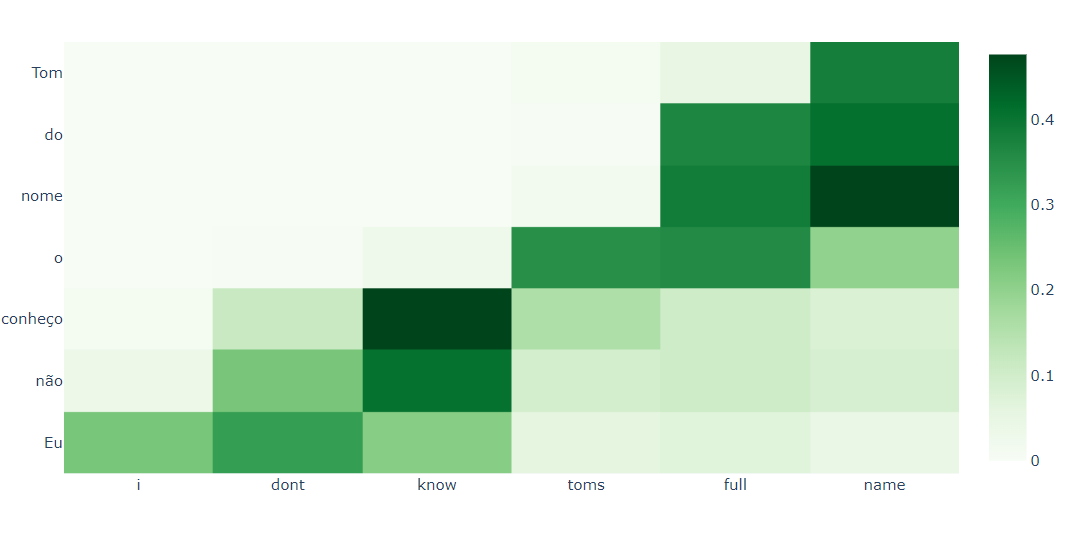

In [28]:
predict_random_val_sentence()

Input: tom said he didnt understand anything
Predicted translation: Tom disse que não entendia nada 
Actual translation: Tom disse que ele não entendeu nada


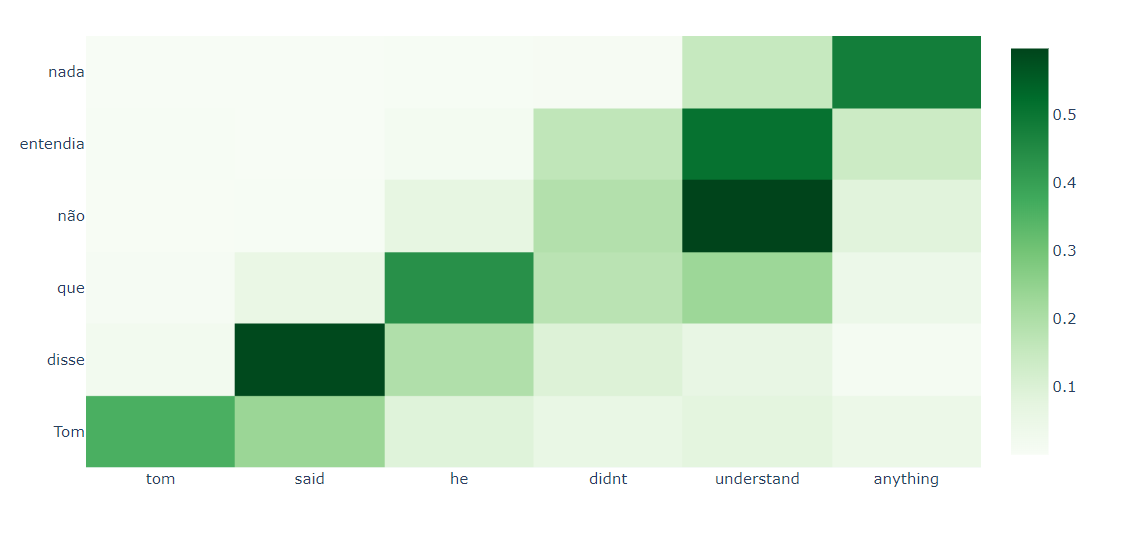

In [29]:
predict_random_val_sentence()

Input: im caught in a traffic jam
Predicted translation: Tô preso em um engarrafamento 
Actual translation: Estou preso em um engarrafamento


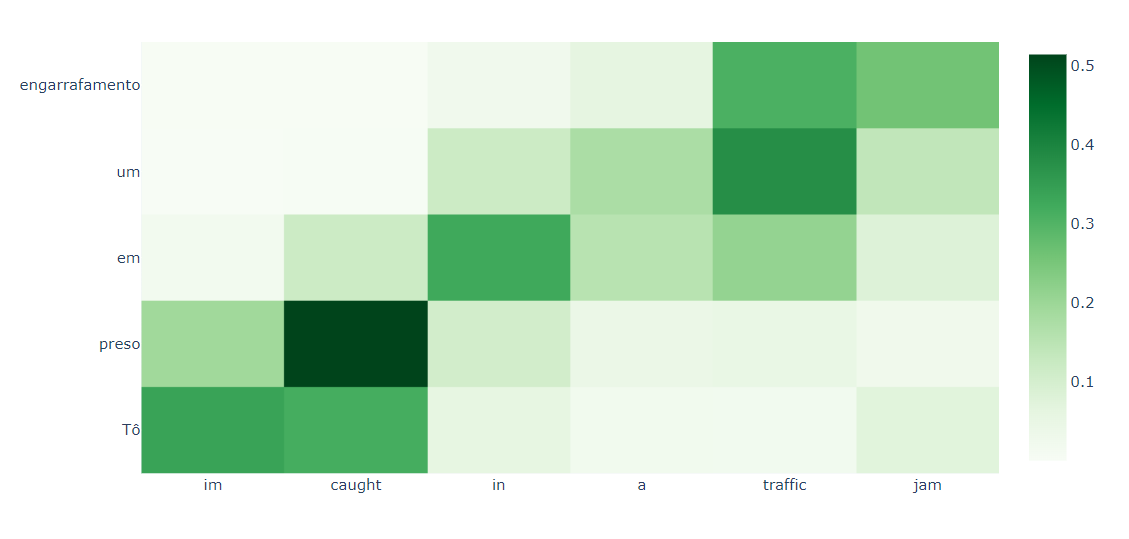

In [30]:
predict_random_val_sentence()

Input: the chiefs gonna kill me
Predicted translation: O conteúdo vão me matar 
Actual translation: O chefe me matará


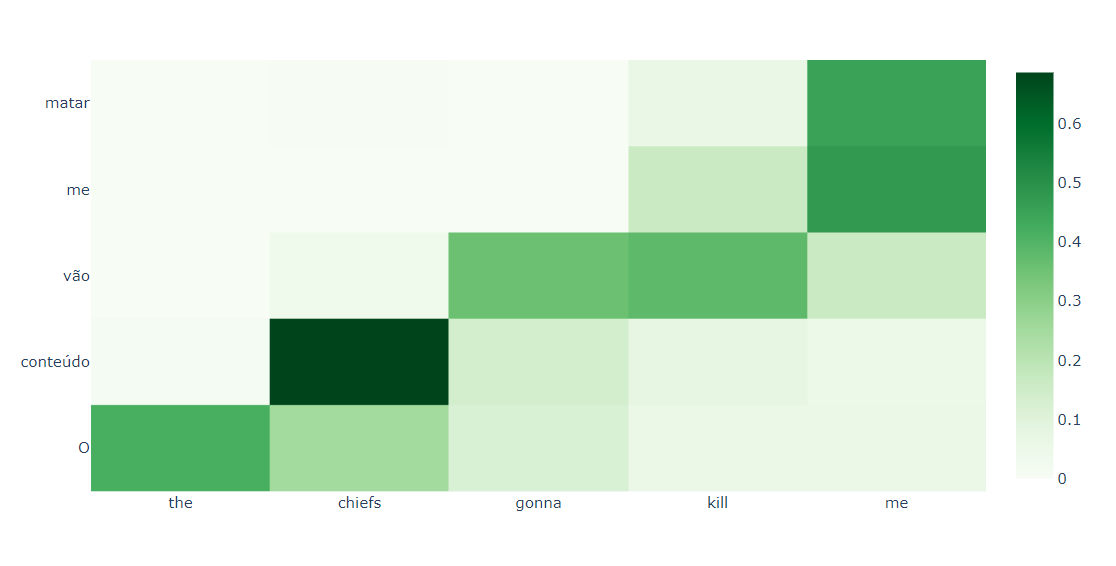

In [31]:
predict_random_val_sentence()

Input: wheres an atm
Predicted translation: Onde está há ruído 
Actual translation: Onde há um caixa eletrônico


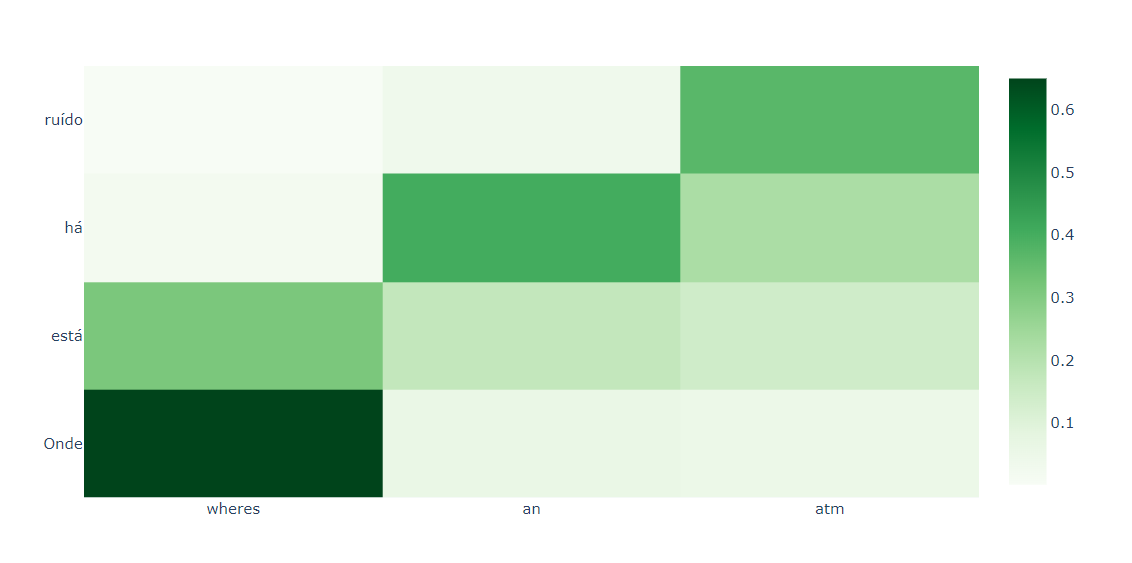

In [32]:
predict_random_val_sentence()

Input: they say that every problem has a solution
Predicted translation: Dizem que todos os problemas 
Actual translation: Eles dzem que todo o problema tem uma solução


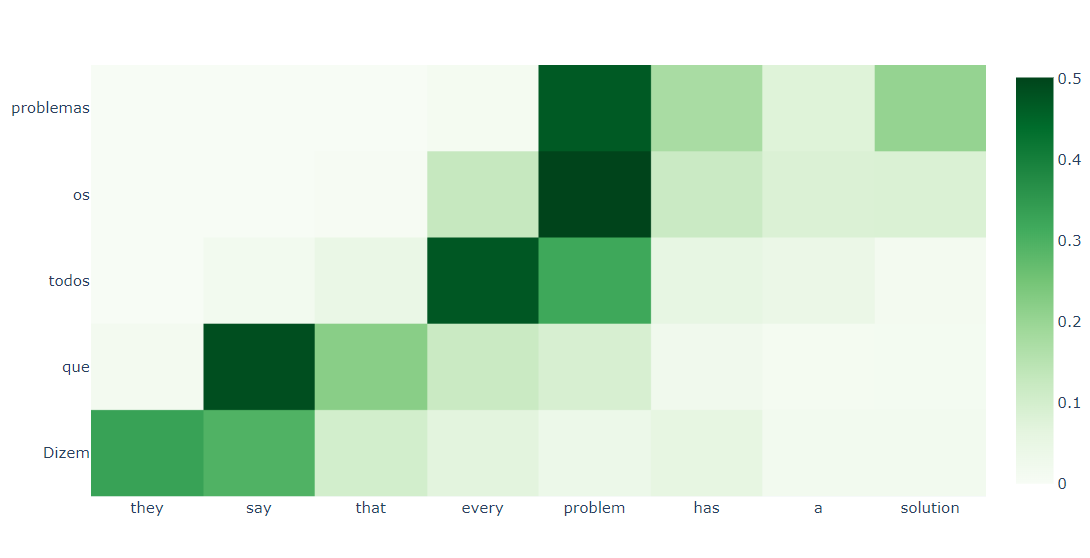

In [33]:
predict_random_val_sentence()

Input: ill bring my sister to the party
Predicted translation: Eu vou trazer a minha irmã para a festa 
Actual translation: Eu vou trazer minha irmã para a festa


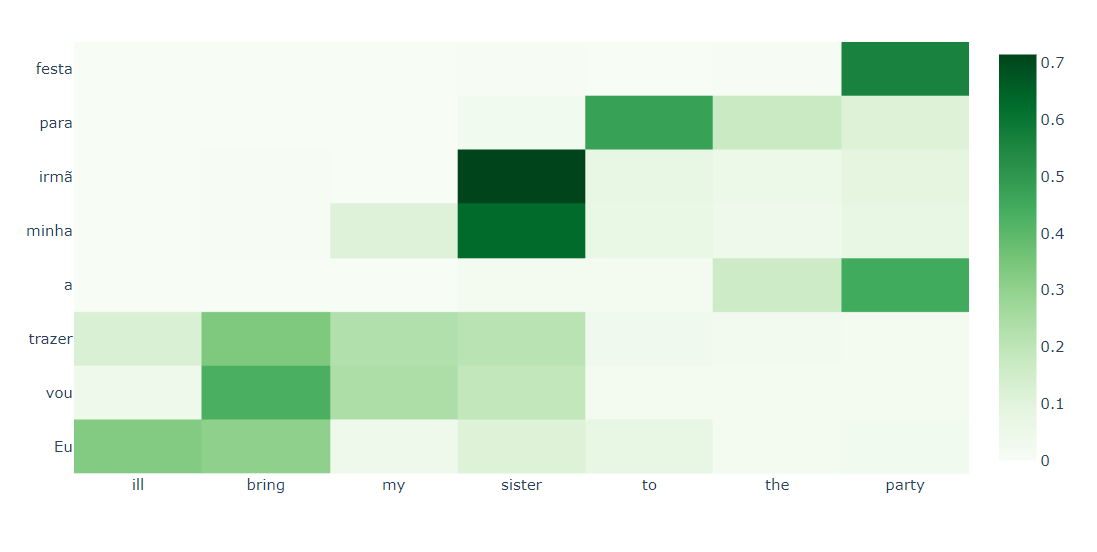

In [34]:
predict_random_val_sentence()

Input: we cant do this without tom
Predicted translation: Nós não podemos fazer isto sem Tom 
Actual translation: Nós não podemos fazer isso sem o Tom


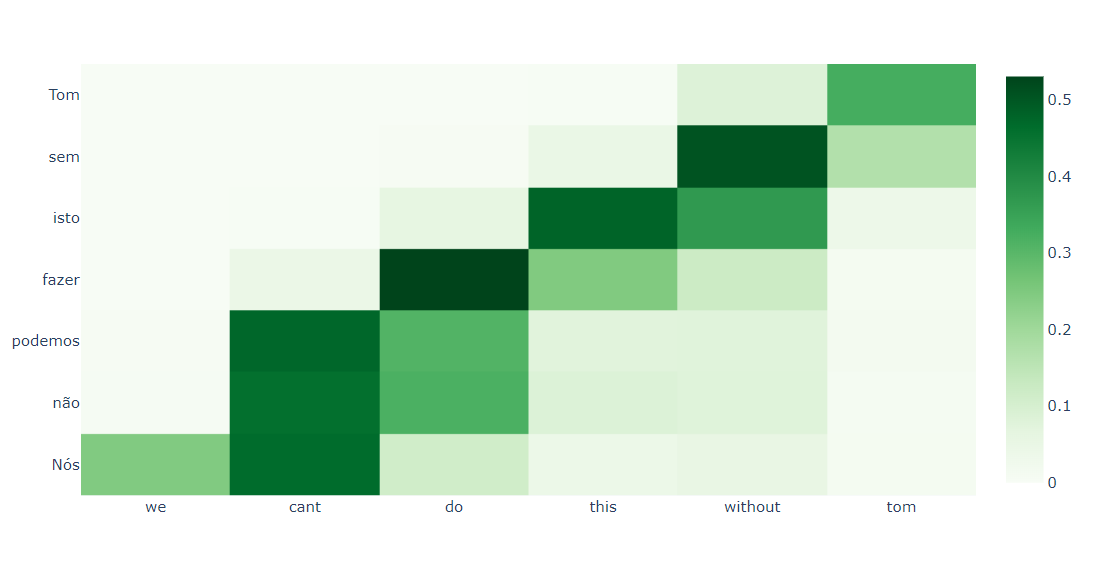